In [12]:
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch

In [13]:
transform = transforms.Compose([
    transforms.RandomRotation(5, resample=False),
    transforms.Resize(250, interpolation=3),
    transforms.CenterCrop(220),
    transforms.RandomCrop(192),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# TODO: Random crop or reshape to 192 x 192
data = datasets.ImageFolder(
    root='data/_screenshots',
    transform=transform)

In [14]:
data

Dataset ImageFolder
    Number of datapoints: 92
    Root Location: data/_screenshots
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-5, 5), resample=False, expand=False)
                             Resize(size=250, interpolation=PIL.Image.BICUBIC)
                             CenterCrop(size=(220, 220))
                             RandomCrop(size=(192, 192), padding=0)
                             ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                         )
    Target Transforms (if any): None

In [15]:
data.classes

['0', '1', '2', '3']

In [16]:
data_classes = [int(i) for i in data.classes]
data_classes

[0, 1, 2, 3]

In [17]:
classes = np.array(
    [np.random.choice(
        data_classes, size=2, replace=False
    ) for i in range(4)] +
    [[np.random.choice(
        data_classes, size=1, replace=True
    )]*2 for i in range(4)]
)
classes

array([[0, 1],
       [0, 1],
       [3, 0],
       [0, 3],
       [3, 3],
       [0, 0],
       [0, 0],
       [1, 1]])

In [18]:
import collections

In [19]:
class SiameseSampler(torch.utils.data.Sampler):
    def __init__(self, data_source, batch_size, n_batches):
        self.data_source = data_source
        self.batch_size = batch_size
        self.n_batches = n_batches

    def __iter__(self):
        return Iterator(self.data_source, self.batch_size, self.n_batches)

    def __len__(self):
        return self.n_batches


class Iterator(collections.Iterator):
    def __init__(self, data_source, batch_size, n_batches):
        self.data_source = data_source
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.current_batch = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_batch < self.n_batches:
            self.current_batch += 1
            data_classes = [int(i) for i in self.data_source.classes]

            classes = np.array(
                [np.random.choice(
                    data_classes, size=2, replace=False
                ) for i in range(self.batch_size // 2)] +
                [[np.random.choice(
                    data_classes, size=1, replace=True
                )] * 2 for i in range(self.batch_size // 2)])

            class_inds = {int(i): [] for i in data_classes}
            for i, sample in enumerate(self.data_source.samples):
                class_inds[sample[1]].append(i)

            def sample_from_class(i):
                return np.random.choice(class_inds[i])

            classes = list(map(sample_from_class, classes.flatten('A')))
            return classes
        raise StopIteration()

In [20]:
sampler = SiameseSampler(data, 8, 3)

In [22]:
for sample in sampler:
    print(sample)

[89, 14, 15, 51, 67, 12, 81, 59, 36, 18, 7, 16, 36, 33, 4, 13]
[1, 72, 41, 45, 21, 12, 45, 14, 42, 61, 72, 87, 64, 62, 12, 11]
[88, 29, 72, 23, 6, 71, 77, 23, 40, 19, 86, 69, 2, 12, 64, 49]


In [23]:
dataloader = torch.utils.data.DataLoader(
    data,
    batch_sampler=SiameseSampler(data, 8, 5))

In [24]:
from matplotlib import pyplot as plt

torch.Size([16, 3, 192, 192])


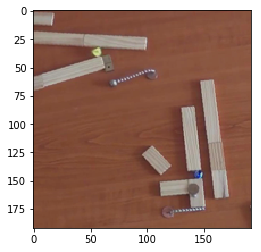

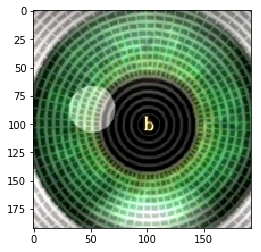

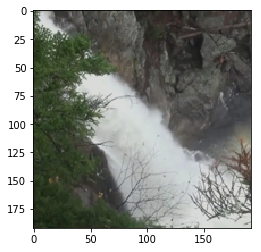

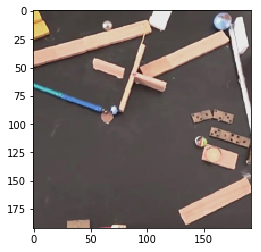

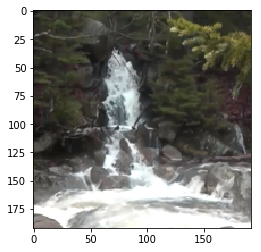

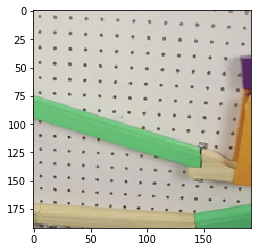

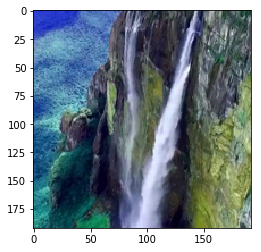

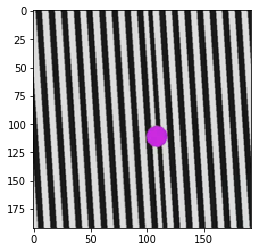

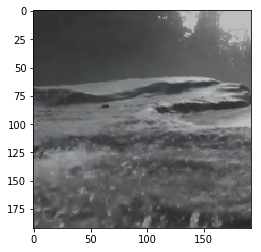

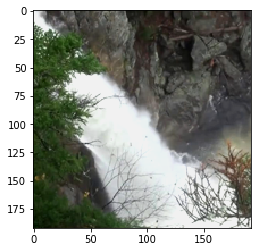

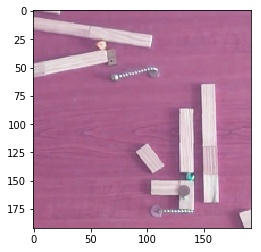

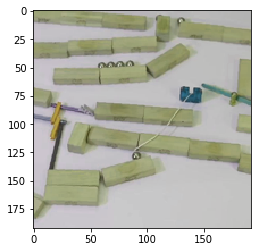

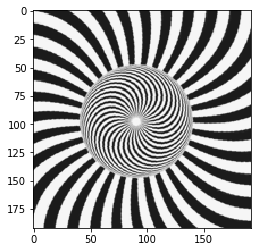

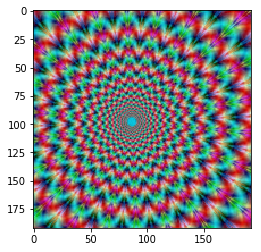

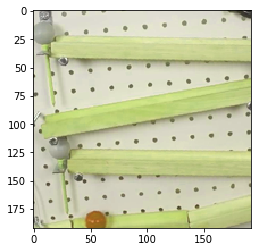

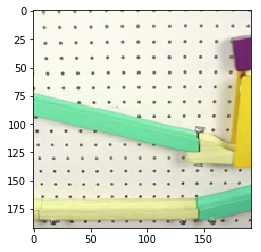

KeyboardInterrupt: 

In [28]:
for i in dataloader:
    print(i[0].shape)
    for ii in i[0].numpy():
        plt.imshow(np.moveaxis(ii, 0, -1))
        plt.show()

In [26]:
import torch
import torchvision.models as models
from torch import nn


class ImageDecoder(nn.Module):
    def __init__(self):
        super(ImageDecoder, self).__init__()

        self.encoder = models.vgg11(pretrained=True).features
        # for p in self.encoder.parameters():
        #     p.requires_grad = False

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        # for p in self.avgpool.parameters():
        #     p.requires_grad = False

        encoder_output_size = 512 * 7 * 7
        fc_sizes = [20, 128 * 12 * 12]
        dc_channels = [256, 128, 64, 32, 3]
        upsample_sizes = [12, 24, 48, 96, 192]
        self.fc_sizes = fc_sizes

        self.to_latent = nn.Sequential(
            nn.Linear(encoder_output_size, fc_sizes[0]),
            nn.ReLU()
        )

        self.from_latent = nn.Sequential(
            nn.Linear(fc_sizes[0], fc_sizes[1]),
            nn.ReLU()
        )

        # self.to_latent = nn.Sequential(
        #     nn.Conv2d(self.encoder_output_size, fc_sizes[0], kernel_size=1),
        #     nn.ReLU()
        # )

        # self.from_latent = nn.Sequential(
        #     nn.Conv2d(fc_sizes[0], fc_sizes[1], kernel_size=1),
        #     nn.ReLU()
        # )

        self.decoder = nn.Sequential(
            nn.Upsample(size=(upsample_sizes[0], upsample_sizes[0])),
            nn.ConvTranspose2d(
                in_channels=fc_sizes[1], out_channels=dc_channels[0],
                kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(size=(upsample_sizes[1], upsample_sizes[1])),
            nn.ConvTranspose2d(
                in_channels=dc_channels[0], out_channels=dc_channels[1],
                kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(size=(upsample_sizes[2], upsample_sizes[2])),
            nn.ConvTranspose2d(
                in_channels=dc_channels[1], out_channels=dc_channels[2],
                kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(size=(upsample_sizes[3], upsample_sizes[3])),
            nn.ConvTranspose2d(
                in_channels=dc_channels[2], out_channels=dc_channels[3],
                kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Upsample(size=(upsample_sizes[4], upsample_sizes[4])),
            nn.ConvTranspose2d(
                in_channels=dc_channels[3], out_channels=dc_channels[4],
                kernel_size=3, padding=1),
            nn.Tanh()
        )

        # for layer in self.encoder:
        #     if isinstance(layer, nn.Conv2d):
        #         nn.init.xavier_uniform(layer.weight)

        print(self.to_latent[0])
        nn.init.xavier_uniform_(self.to_latent[0].weight)
        nn.init.xavier_uniform_(self.from_latent[0].weight)

        for layer in self.decoder:
            if isinstance(layer, nn.ConvTranspose2d):
                print(layer)
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = self.encoder(x)
        x = self.avgpool(x)
        #x = torch.flatten(x, 1).reshape(-1, self.encoder_output_size, 1, 1)
        x = torch.flatten(x, 1)
        latent = self.to_latent(x)
        # latent_out = latent.flatten(1)
        # print(f"to_latent {latent.size()}")
        x = self.from_latent(latent)
        # print(f"from_latent {x.size()}")
        x = x.view(-1, self.fc_sizes[-1], 1, 1)
        # print(f"reshape {x.size()}")
        x = self.decoder(x)
        # print(f"decoder {x.size()}")
        return latent, x
    pass

In [100]:
model = ImageDecoder()

Linear(in_features=25088, out_features=20, bias=True)
ConvTranspose2d(18432, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [101]:
model.load_state_dict(torch.load('runs/image_decoder/2019.11.09-13.27(no_descr)/model_best.pth'))

In [103]:
def get_grad_sum(model):
    grads = {}
    # nans = 0
    for name, param in model.named_parameters():
        grads[name] = param.data.sum()
    return grads  #, nans

In [104]:
get_grad_sum(model)

{'decoder.1.bias': tensor(-0.4298),
 'decoder.1.weight': tensor(-2243.1968),
 'decoder.10.bias': tensor(-0.1039),
 'decoder.10.weight': tensor(0.5025),
 'decoder.13.bias': tensor(0.2642),
 'decoder.13.weight': tensor(6.1718),
 'decoder.4.bias': tensor(-0.0337),
 'decoder.4.weight': tensor(4.2332),
 'decoder.7.bias': tensor(-0.2655),
 'decoder.7.weight': tensor(3.8859),
 'encoder.0.bias': tensor(-12.3808),
 'encoder.0.weight': tensor(-2.7315),
 'encoder.11.bias': tensor(5.5617),
 'encoder.11.weight': tensor(-2108.9175),
 'encoder.13.bias': tensor(23.3978),
 'encoder.13.weight': tensor(-5754.3970),
 'encoder.16.bias': tensor(8.4866),
 'encoder.16.weight': tensor(-3987.7546),
 'encoder.18.bias': tensor(42.8547),
 'encoder.18.weight': tensor(-6325.2217),
 'encoder.3.bias': tensor(3.9922),
 'encoder.3.weight': tensor(-325.1448),
 'encoder.6.bias': tensor(11.6312),
 'encoder.6.weight': tensor(-622.4280),
 'encoder.8.bias': tensor(9.3784),
 'encoder.8.weight': tensor(-1501.0651),
 'from_laten

In [106]:
latents = []
labels = []

for i, batch in enumerate(dataloader):
    print(i)
    labels.append(batch[-1])
            
    batch = torch.cat(batch[:-1], 0)
    
    latent, _ = model(batch)
    latents.append(latent)

0


/Users/utanashati/miniconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


1
2
3
4


In [107]:
latents = torch.cat(latents, 0).detach().numpy()
labels = torch.cat(labels).detach().numpy()

In [108]:
latents.shape

(80, 20)

In [109]:
labels.shape

(80,)

In [110]:
latents

array([[0.        , 0.        , 0.0384635 , ..., 0.        , 0.        ,
        0.04589536],
       [0.        , 0.        , 1.0586978 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.34334138],
       ...,
       [0.        , 0.        , 0.12064048, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.2070968 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [111]:
np.savetxt('latents.txt', latents)

In [112]:
np.savetxt('labels.txt', labels)